Basic pseudotime analysis
=========================

The objective of this notebook is to learn how to perform tree inference from single cell data, starting from a count matrix.
Significant features that significantly changes along the tree will then be extracted and clustered.

## Importing modules and basic settings

In [1]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import palantir
import scFates as scf
%matplotlib inline

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6))

## Load data and run pipeline from Palantir

This cell follows the [palantir tutorial notebook](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) with some slight changes. Doing palantir diffusion maps is usually a good pre-preprocessing step before using elpigraph or ppt.

In [3]:
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
norm_df=sc.pp.normalize_per_cell(counts,copy=True)
norm_df = palantir.preprocess.log_transform(norm_df)
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)
tsne = palantir.utils.run_tsne(ms_data,n_jobs=20)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors


Determing nearest neighbor graph...


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [4]:
adata.obsm["X_palantir"]=ms_data.values
adata.obsm["X_tsne"]=tsne.values

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


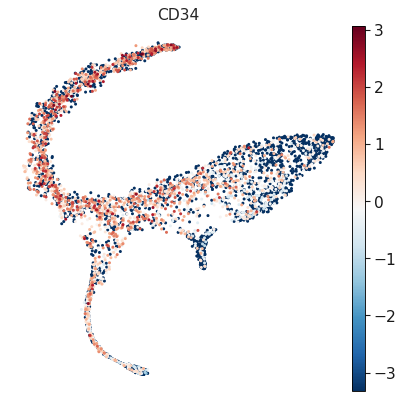

In [5]:
sc.pl.tsne(adata,color="CD34",color_map="RdBu_r")

## Learn tree using ElPiGraph algorithm

We will infer a principal tree on the multiscale diffusion space generated by Palantir. Any dimensionality reduction in `.obsm` can be selected using `use_rep` parameter. The method for tree learning is defined by `method` parameter: Here we choose ElPiGraph ('epg').  

In [6]:
scf.tl.tree(adata,method="epg",Nodes=50,use_rep="palantir",
            device="gpu",seed=1,epg_lambda= .05)

inferring a principal tree --> parameters used 
    50 principal points, mu = 0.1, lambda = 0.05
    finished (0:00:27) --> added 
    .uns['epg'] dictionnary containing inferred elastic tree generated from elpigraph.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] hard assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.


## Projecting the tree on the tsne computed from Palantir

By default the plot function will annotate automatically the tips and the forks ids.

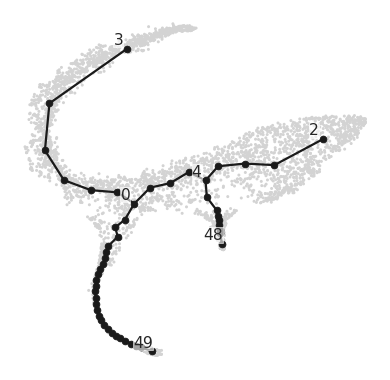

In [7]:
scf.pl.graph(adata,basis="tsne")

## Selecting a root and computing pseudotime

Using CD34 marker, we can confidently tell that the tip 3 is the root.

In [8]:
scf.tl.root(adata,3)

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Having the root selected, we can now project the cells onto the tree and compute the pseudotime value for each of them.

In [9]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


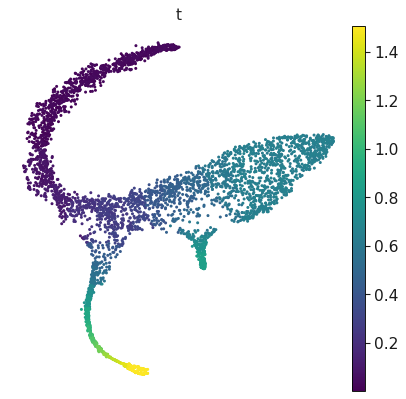

In [10]:
sc.pl.tsne(adata,color="t",cmap="viridis")

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


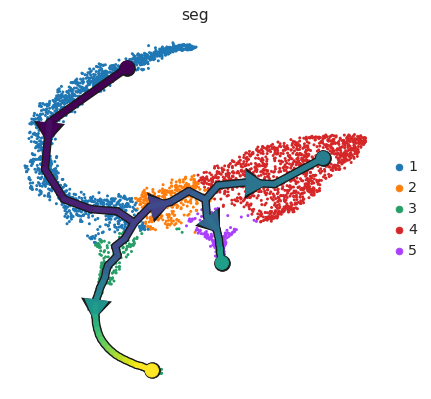

In [11]:
scf.pl.trajectory(adata,basis="tsne",color_cells="seg",arrows=True,arrow_offset=1)

## Test and fit associated features associated with the tree

Let's find out which genes are significantly changing along the tree.

In [12]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    mapping 0: 100%|██████████| 16106/16106 [03:33<00:00, 75.32it/s]
    found 3110 significant features (0:03:35) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


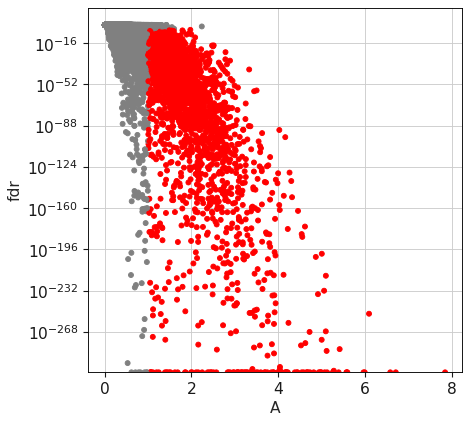

In [13]:
scf.pl.test_association(adata)

We can now fit the significant genes.

<div class="alert alert-warning">
    
**Warning**

anndata format can currently only keep the same dimensions for each of its layers. This means that adding the layer for fitted features will lead to dataset subsetted to only those! 

By default the function fit will keep the whole dataset under **adata.raw** (parameter save_raw)

</div>

In [14]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    mapping 0: 100%|██████████| 3110/3110 [01:42<00:00, 30.46it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:52) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


## Plot single features

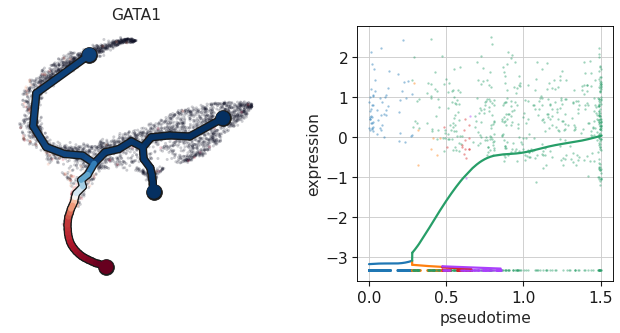

In [15]:
scf.pl.single_trend(adata,feature="GATA1",basis="tsne",alpha=.2)

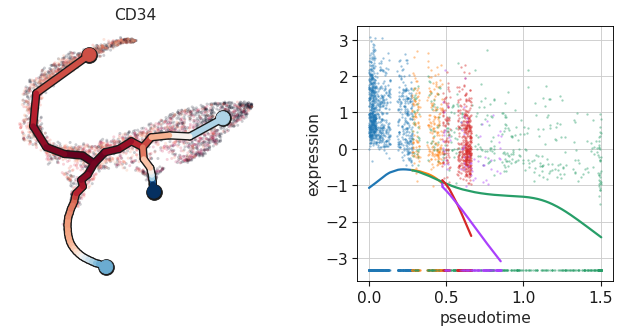

In [16]:
scf.pl.single_trend(adata,feature="CD34",basis="tsne",alpha=.2)

## Cluster and plot fitted features

In [17]:
scf.tl.cluster(adata,knn=300,metric="correlation",device="gpu")

    clustering using grapheno
Finding 300 nearest neighbors using correlation metric and brute algorithm...
Neighbors computed in 0.856558084487915 seconds...
Computing Jaccard similarity...
jaccard graph constructed in 0.024359703063964844 seconds...
Running Louvain modularity optimization...
grapheno completed in 1.2863011360168457 seconds...
Communities detected: 5
Modularity: 0.5290549993515015
    finished (0:00:05) --> added
    .var['fit_clusters'], cluster assignments for features.


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


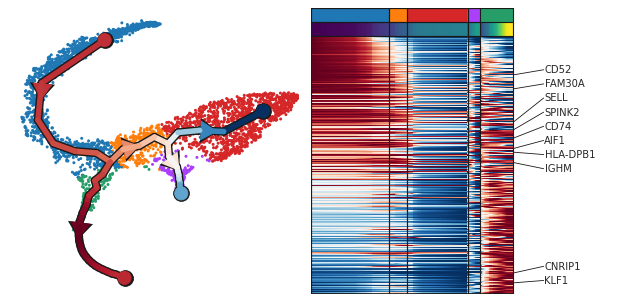

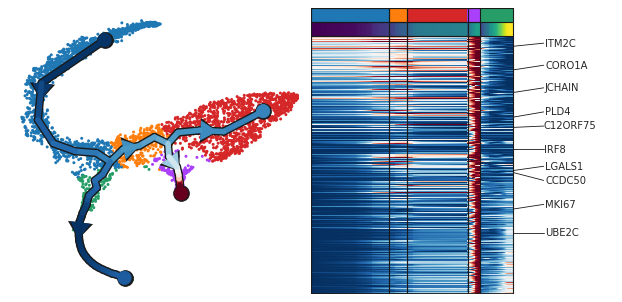

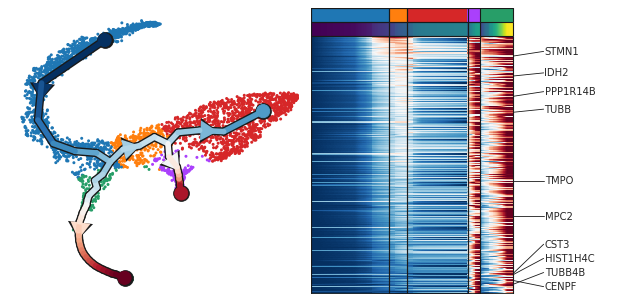

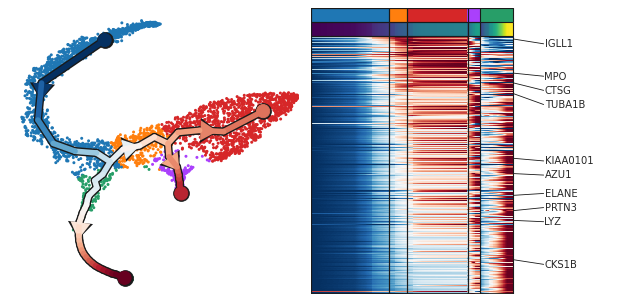

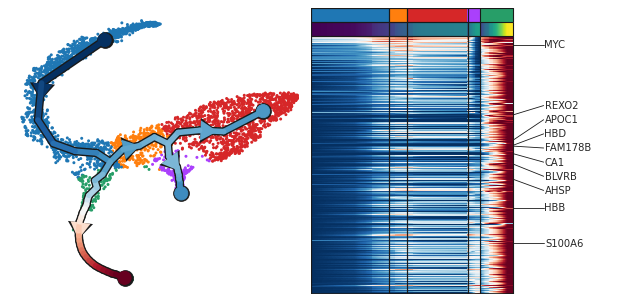

In [18]:
for c in pd.Series(adata.var["fit_clusters"]).unique():
    scf.pl.trends(adata,features=adata.var_names[adata.var.fit_clusters==c],basis="tsne",annot="seg",arrows=True,arrow_offset=1)